# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a7cc19528d78d9f3b63ebab06b3377a854ea96c061577d07a7f37c836e37effe
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=0529efadd62c60ea74a56d0bf681f39eedaaa60577021c8956d89025dc327115
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),
                                             v2.RandomVerticalFlip(),
                                             v2.RandomRotation(180) , 
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 28: 


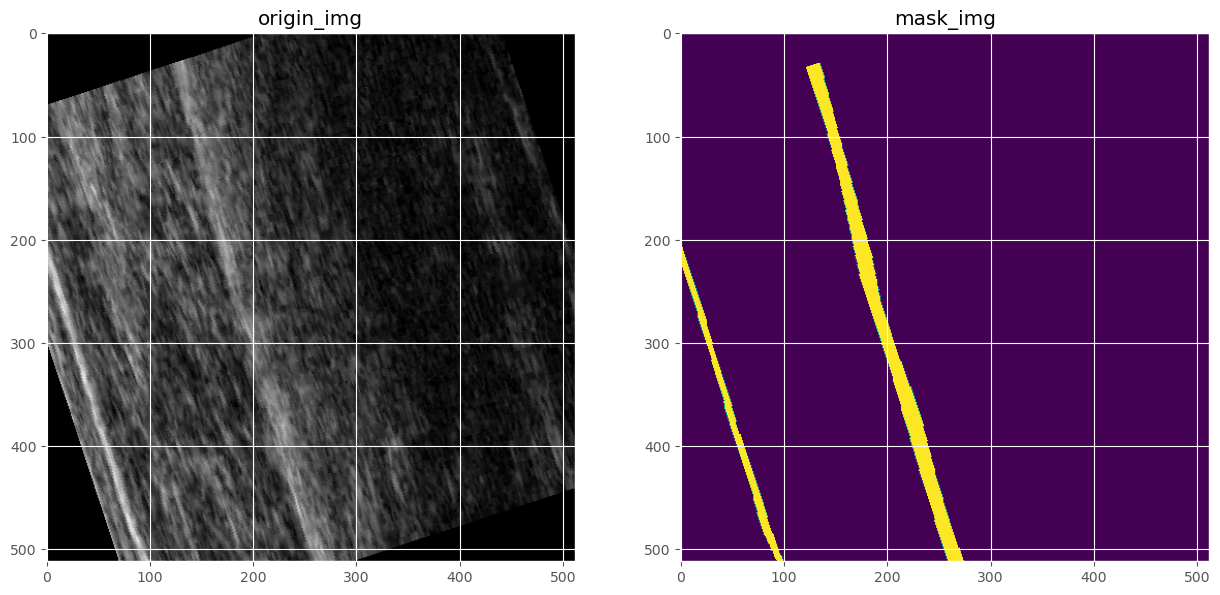

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = v2.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240117_174925-fnmdidxn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bumbling-rain-17
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/fnmdidxn
Epoch 1/60:  20%|█▉        | 90/456 [00:17<01:02,  5.86img/s, loss (batch)=0.908]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 2.9403557777404785, IoU Score 0.25520506501197815


Epoch 1/60:  39%|███▉      | 180/456 [00:47<00:48,  5.75img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 2.6331164836883545, IoU Score 0.21363402903079987


Epoch 1/60:  59%|█████▉    | 270/456 [01:17<00:32,  5.72img/s, loss (batch)=0.881]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 2.4539005756378174, IoU Score 0.26081860065460205


Epoch 1/60:  79%|███████▉  | 360/456 [01:47<00:16,  5.70img/s, loss (batch)=0.806]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 2.2909603118896484, IoU Score 0.3227575421333313


Epoch 1/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.78img/s, loss (batch)=0.799]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 2.484475612640381, IoU Score 0.2574288547039032


Epoch 2/60:  18%|█▊        | 84/456 [00:14<01:04,  5.74img/s, loss (batch)=0.891]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 2.2110142707824707, IoU Score 0.37715137004852295


Epoch 2/60:  38%|███▊      | 174/456 [00:44<00:48,  5.82img/s, loss (batch)=0.89] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 2.1733152866363525, IoU Score 0.3861159384250641


Epoch 2/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.73img/s, loss (batch)=0.874]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 2.046420097351074, IoU Score 0.4052048921585083


Epoch 2/60:  78%|███████▊  | 354/456 [01:44<00:17,  5.85img/s, loss (batch)=0.778]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 2.1650607585906982, IoU Score 0.3395538628101349


Epoch 2/60:  97%|█████████▋| 444/456 [02:14<00:02,  5.77img/s, loss (batch)=0.757]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 2.385580539703369, IoU Score 0.25502872467041016


Epoch 3/60:  17%|█▋        | 78/456 [00:13<01:05,  5.78img/s, loss (batch)=0.876]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.9216232299804688, IoU Score 0.40939605236053467


Epoch 3/60:  37%|███▋      | 168/456 [00:43<00:50,  5.71img/s, loss (batch)=0.847]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.9226056337356567, IoU Score 0.3865697383880615


Epoch 3/60:  57%|█████▋    | 258/456 [01:13<00:33,  5.84img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.9590283632278442, IoU Score 0.35738399624824524


Epoch 3/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.71img/s, loss (batch)=0.798]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.8967530727386475, IoU Score 0.38651242852211


Epoch 3/60:  96%|█████████▌| 438/456 [02:13<00:03,  5.81img/s, loss (batch)=0.747]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.9224199056625366, IoU Score 0.4049941599369049


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:06,  5.81img/s, loss (batch)=0.681]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.8060730695724487, IoU Score 0.4328889846801758


Epoch 4/60:  36%|███▌      | 162/456 [00:42<00:51,  5.66img/s, loss (batch)=0.826]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.7933517694473267, IoU Score 0.4480190575122833


Epoch 4/60:  55%|█████▌    | 252/456 [01:12<00:34,  5.86img/s, loss (batch)=0.725]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.7885487079620361, IoU Score 0.4394398331642151


Epoch 4/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.70img/s, loss (batch)=0.835]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.7521535158157349, IoU Score 0.46844449639320374


Epoch 4/60:  95%|█████████▍| 432/456 [02:13<00:04,  5.73img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.708408236503601, IoU Score 0.45081788301467896


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:08,  5.65img/s, loss (batch)=0.859]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.8126146793365479, IoU Score 0.4060620963573456


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:52,  5.71img/s, loss (batch)=0.734]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.746488094329834, IoU Score 0.4398302733898163


Epoch 5/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.82img/s, loss (batch)=0.839]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.7309859991073608, IoU Score 0.4326072633266449


Epoch 5/60:  74%|███████▎  | 336/456 [01:42<00:21,  5.61img/s, loss (batch)=0.801]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6823325157165527, IoU Score 0.4509184956550598


Epoch 5/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.74img/s, loss (batch)=0.591]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.660768747329712, IoU Score 0.45523902773857117


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:08,  5.79img/s, loss (batch)=0.728]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.660321593284607, IoU Score 0.4688461124897003


Epoch 6/60:  33%|███▎      | 150/456 [00:40<00:52,  5.83img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.643447756767273, IoU Score 0.45708346366882324


Epoch 6/60:  53%|█████▎    | 240/456 [01:10<00:37,  5.71img/s, loss (batch)=0.706]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.66539466381073, IoU Score 0.45671018958091736


Epoch 6/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.65img/s, loss (batch)=0.686]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.57753324508667, IoU Score 0.4802135229110718


Epoch 6/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.72img/s, loss (batch)=0.689]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.5669358968734741, IoU Score 0.4690207242965698


Epoch 7/60:  12%|█▏        | 54/456 [00:09<01:08,  5.84img/s, loss (batch)=0.621]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.5608806610107422, IoU Score 0.4846985340118408


Epoch 7/60:  32%|███▏      | 144/456 [00:39<00:54,  5.73img/s, loss (batch)=0.774]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.5986570119857788, IoU Score 0.4625239372253418


Epoch 7/60:  51%|█████▏    | 234/456 [01:09<00:38,  5.78img/s, loss (batch)=0.723]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.5466183423995972, IoU Score 0.4845987856388092


Epoch 7/60:  71%|███████   | 324/456 [01:40<00:23,  5.60img/s, loss (batch)=0.68] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.5104573965072632, IoU Score 0.4739949405193329


Epoch 7/60:  91%|█████████ | 414/456 [02:10<00:07,  5.78img/s, loss (batch)=0.687]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.4921594858169556, IoU Score 0.48509952425956726


Epoch 8/60:  11%|█         | 48/456 [00:08<01:10,  5.79img/s, loss (batch)=0.598]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.4704610109329224, IoU Score 0.48033225536346436


Epoch 8/60:  30%|███       | 138/456 [00:38<00:56,  5.64img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.5013384819030762, IoU Score 0.5066236853599548


Epoch 8/60:  50%|█████     | 228/456 [01:08<00:39,  5.75img/s, loss (batch)=0.808]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.4877969026565552, IoU Score 0.49290603399276733


Epoch 8/60:  70%|██████▉   | 318/456 [01:38<00:24,  5.60img/s, loss (batch)=0.613]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.4856748580932617, IoU Score 0.49424418807029724


Epoch 8/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.79img/s, loss (batch)=0.618]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.5010383129119873, IoU Score 0.4844861626625061


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:11,  5.79img/s, loss (batch)=0.605]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.4450594186782837, IoU Score 0.49497124552726746


Epoch 9/60:  29%|██▉       | 132/456 [00:37<00:56,  5.74img/s, loss (batch)=0.791]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.4794809818267822, IoU Score 0.48336148262023926


Epoch 9/60:  49%|████▊     | 222/456 [01:07<00:40,  5.84img/s, loss (batch)=0.641]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.4165781736373901, IoU Score 0.46297428011894226


Epoch 9/60:  68%|██████▊   | 312/456 [01:37<00:25,  5.76img/s, loss (batch)=0.692]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.4278887510299683, IoU Score 0.4959598183631897


Epoch 9/60:  88%|████████▊ | 402/456 [02:07<00:09,  5.76img/s, loss (batch)=0.599]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.4532285928726196, IoU Score 0.4952374994754791


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:12,  5.82img/s, loss (batch)=0.54] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.4067878723144531, IoU Score 0.5056631565093994


Epoch 10/60:  28%|██▊       | 126/456 [00:36<00:57,  5.73img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.4162501096725464, IoU Score 0.5208455324172974


Epoch 10/60:  47%|████▋     | 216/456 [01:06<00:41,  5.74img/s, loss (batch)=0.661]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.4209831953048706, IoU Score 0.4906310439109802


Epoch 10/60:  67%|██████▋   | 306/456 [01:36<00:26,  5.67img/s, loss (batch)=0.771]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.4104949235916138, IoU Score 0.4880079925060272


Epoch 10/60:  87%|████████▋ | 396/456 [02:06<00:10,  5.79img/s, loss (batch)=0.639]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.366185188293457, IoU Score 0.5049330592155457


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:13,  5.80img/s, loss (batch)=0.594]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3372632265090942, IoU Score 0.5104023814201355


Epoch 11/60:  26%|██▋       | 120/456 [00:35<00:58,  5.79img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.3220528364181519, IoU Score 0.5040309429168701


Epoch 11/60:  46%|████▌     | 210/456 [01:05<00:42,  5.75img/s, loss (batch)=0.576]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.3283390998840332, IoU Score 0.5133379101753235


Epoch 11/60:  66%|██████▌   | 300/456 [01:35<00:27,  5.73img/s, loss (batch)=0.616]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.407711386680603, IoU Score 0.4915028214454651


Epoch 11/60:  86%|████████▌ | 390/456 [02:05<00:11,  5.71img/s, loss (batch)=0.623]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.3506232500076294, IoU Score 0.5064183473587036


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:15,  5.70img/s, loss (batch)=0.601]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4114034175872803, IoU Score 0.5016510486602783


Epoch 12/60:  25%|██▌       | 114/456 [00:34<00:58,  5.80img/s, loss (batch)=0.634]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.4644416570663452, IoU Score 0.44064968824386597


Epoch 12/60:  45%|████▍     | 204/456 [01:04<00:43,  5.83img/s, loss (batch)=0.58] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.3040306568145752, IoU Score 0.5029802918434143


Epoch 12/60:  64%|██████▍   | 294/456 [01:34<00:28,  5.79img/s, loss (batch)=0.708]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.3150250911712646, IoU Score 0.5126822590827942


Epoch 12/60:  84%|████████▍ | 384/456 [02:04<00:12,  5.79img/s, loss (batch)=0.517]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.30630624294281, IoU Score 0.5108790397644043


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:15,  5.84img/s, loss (batch)=0.563]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.3393174409866333, IoU Score 0.48958587646484375


Epoch 13/60:  24%|██▎       | 108/456 [00:33<00:59,  5.86img/s, loss (batch)=0.515]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.3867465257644653, IoU Score 0.48367592692375183


Epoch 13/60:  43%|████▎     | 198/456 [01:03<00:45,  5.73img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.2893917560577393, IoU Score 0.515462338924408


Epoch 13/60:  63%|██████▎   | 288/456 [01:33<00:29,  5.76img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.2987174987792969, IoU Score 0.5117507576942444


Epoch 13/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.80img/s, loss (batch)=0.711]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.282036542892456, IoU Score 0.5117260217666626


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:17,  5.73img/s, loss (batch)=0.701]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.2871780395507812, IoU Score 0.4952239692211151


Epoch 14/60:  22%|██▏       | 102/456 [00:32<01:01,  5.74img/s, loss (batch)=0.544]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3279945850372314, IoU Score 0.5047945976257324


Epoch 14/60:  42%|████▏     | 192/456 [01:02<00:44,  5.93img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.2195589542388916, IoU Score 0.5180909633636475


Epoch 14/60:  62%|██████▏   | 282/456 [01:32<00:30,  5.77img/s, loss (batch)=0.712]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.3236331939697266, IoU Score 0.48840975761413574


Epoch 14/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.77img/s, loss (batch)=0.513]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.2989979982376099, IoU Score 0.5060210824012756


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:15,  5.99img/s, loss (batch)=0.517]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.276984691619873, IoU Score 0.5013989210128784


Epoch 15/60:  21%|██        | 96/456 [00:30<01:02,  5.73img/s, loss (batch)=0.612]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.32630455493927, IoU Score 0.4970192611217499


Epoch 15/60:  41%|████      | 186/456 [01:01<00:46,  5.85img/s, loss (batch)=0.498]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3034999370574951, IoU Score 0.49972566962242126


Epoch 15/60:  61%|██████    | 276/456 [01:31<00:31,  5.68img/s, loss (batch)=0.599]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.273295283317566, IoU Score 0.5061200857162476


Epoch 15/60:  80%|████████  | 366/456 [02:01<00:16,  5.61img/s, loss (batch)=0.836]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.275899887084961, IoU Score 0.5099976062774658


Epoch 15/60: 100%|██████████| 456/456 [02:31<00:00,  5.79img/s, loss (batch)=0.45]

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:45<00:00,  2.75img/s, loss (batch)=0.45]


Validation dice loss: 1.2105151414871216, IoU Score 0.5240448713302612


Epoch 16/60:  20%|█▉        | 90/456 [00:15<01:02,  5.84img/s, loss (batch)=0.441]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.1961631774902344, IoU Score 0.5168284773826599


Epoch 16/60:  39%|███▉      | 180/456 [00:45<00:49,  5.60img/s, loss (batch)=0.67] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.3311914205551147, IoU Score 0.4658140540122986


Epoch 16/60:  59%|█████▉    | 270/456 [01:15<00:31,  5.84img/s, loss (batch)=0.514]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.1267622709274292, IoU Score 0.5532578229904175


Epoch 16/60:  79%|███████▉  | 360/456 [01:46<00:16,  5.94img/s, loss (batch)=0.459]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.3018131256103516, IoU Score 0.49032357335090637


Epoch 16/60:  99%|█████████▊| 450/456 [02:16<00:01,  5.79img/s, loss (batch)=0.512]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.2822589874267578, IoU Score 0.49344390630722046


Epoch 17/60:  18%|█▊        | 84/456 [00:14<01:03,  5.85img/s, loss (batch)=0.517]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.2346465587615967, IoU Score 0.518506646156311


Epoch 17/60:  38%|███▊      | 174/456 [00:44<00:48,  5.83img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.2227143049240112, IoU Score 0.5062897801399231


Epoch 17/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.66img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.1788506507873535, IoU Score 0.5049786567687988


Epoch 17/60:  78%|███████▊  | 354/456 [01:44<00:17,  5.87img/s, loss (batch)=0.459]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.342330813407898, IoU Score 0.4494840204715729


Epoch 17/60:  97%|█████████▋| 444/456 [02:14<00:02,  5.73img/s, loss (batch)=0.514]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.2267837524414062, IoU Score 0.4995415210723877


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:05,  5.81img/s, loss (batch)=0.441]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.2343519926071167, IoU Score 0.5066179633140564


Epoch 18/60:  37%|███▋      | 168/456 [00:43<00:49,  5.80img/s, loss (batch)=0.538]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.3510586023330688, IoU Score 0.4509783685207367


Epoch 18/60:  57%|█████▋    | 258/456 [01:13<00:33,  5.88img/s, loss (batch)=0.402]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.163743019104004, IoU Score 0.49971461296081543


Epoch 18/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.82img/s, loss (batch)=0.471]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.1176255941390991, IoU Score 0.5348241925239563


Epoch 18/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.72img/s, loss (batch)=0.665]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.0873069763183594, IoU Score 0.5315004587173462


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:06,  5.77img/s, loss (batch)=0.463]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.1559245586395264, IoU Score 0.5310115218162537


Epoch 19/60:  36%|███▌      | 162/456 [00:42<00:50,  5.77img/s, loss (batch)=0.548]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.102381944656372, IoU Score 0.5321685671806335


Epoch 19/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.71img/s, loss (batch)=0.575]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.1745985746383667, IoU Score 0.5020256638526917


Epoch 19/60:  75%|███████▌  | 342/456 [01:42<00:19,  5.77img/s, loss (batch)=0.524]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.3378480672836304, IoU Score 0.42466792464256287


Epoch 19/60:  95%|█████████▍| 432/456 [02:12<00:04,  5.67img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.2513347864151, IoU Score 0.4647863507270813


Epoch 20/60:  14%|█▍        | 66/456 [00:11<01:08,  5.71img/s, loss (batch)=0.587]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3428034782409668, IoU Score 0.4446028470993042


Epoch 20/60:  34%|███▍      | 156/456 [00:41<00:52,  5.66img/s, loss (batch)=0.589]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.222877025604248, IoU Score 0.4878183901309967


Epoch 20/60:  54%|█████▍    | 246/456 [01:11<00:35,  5.87img/s, loss (batch)=0.769]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.2507988214492798, IoU Score 0.4672392010688782


Epoch 20/60:  74%|███████▎  | 336/456 [01:41<00:20,  5.72img/s, loss (batch)=0.669]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.3334251642227173, IoU Score 0.4600439965724945


Epoch 20/60:  93%|█████████▎| 426/456 [02:11<00:05,  5.87img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.3101249933242798, IoU Score 0.4533490538597107


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:07,  5.89img/s, loss (batch)=0.358]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.186439037322998, IoU Score 0.5026267766952515


Epoch 21/60:  33%|███▎      | 150/456 [00:40<00:53,  5.77img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.319976568222046, IoU Score 0.4422096312046051


Epoch 21/60:  53%|█████▎    | 240/456 [01:10<00:36,  5.91img/s, loss (batch)=0.471]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.0844906568527222, IoU Score 0.5345561504364014


Epoch 21/60:  72%|███████▏  | 330/456 [01:40<00:21,  5.77img/s, loss (batch)=0.662]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.418095350265503, IoU Score 0.41193798184394836


Epoch 21/60:  92%|█████████▏| 420/456 [02:10<00:06,  5.84img/s, loss (batch)=0.381]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.3421645164489746, IoU Score 0.42541345953941345


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:10,  5.74img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.3325461149215698, IoU Score 0.4086017906665802


Epoch 22/60:  32%|███▏      | 144/456 [00:39<00:54,  5.76img/s, loss (batch)=0.705]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.3703263998031616, IoU Score 0.415351539850235


Epoch 22/60:  51%|█████▏    | 234/456 [01:10<00:37,  5.87img/s, loss (batch)=0.428]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.2648097276687622, IoU Score 0.4643072783946991


Epoch 22/60:  71%|███████   | 324/456 [01:40<00:22,  5.76img/s, loss (batch)=0.386]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.1223124265670776, IoU Score 0.5044751167297363


Epoch 22/60:  91%|█████████ | 414/456 [02:10<00:07,  5.72img/s, loss (batch)=0.55] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.3194689750671387, IoU Score 0.4594458043575287


Epoch 23/60:  11%|█         | 48/456 [00:08<01:11,  5.73img/s, loss (batch)=0.56] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.1853159666061401, IoU Score 0.5025068521499634


Epoch 23/60:  30%|███       | 138/456 [00:38<00:54,  5.85img/s, loss (batch)=0.507]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.1119071245193481, IoU Score 0.5082654356956482


Epoch 23/60:  50%|█████     | 228/456 [01:08<00:38,  5.86img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.1648656129837036, IoU Score 0.4884086847305298


Epoch 23/60:  70%|██████▉   | 318/456 [01:38<00:23,  5.82img/s, loss (batch)=0.585]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.1103729009628296, IoU Score 0.5156897306442261


Epoch 23/60:  89%|████████▉ | 408/456 [02:08<00:08,  5.78img/s, loss (batch)=0.523]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.2030442953109741, IoU Score 0.4554971754550934


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:12,  5.74img/s, loss (batch)=0.54] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.1870826482772827, IoU Score 0.49305543303489685


Epoch 24/60:  29%|██▉       | 132/456 [00:37<00:56,  5.75img/s, loss (batch)=0.467]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6801464557647705, IoU Score 0.32498887181282043


Epoch 24/60:  49%|████▊     | 222/456 [01:07<00:39,  5.91img/s, loss (batch)=0.4]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.9947779774665833, IoU Score 0.5437353253364563


Epoch 24/60:  68%|██████▊   | 312/456 [01:37<00:24,  5.81img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.1727961301803589, IoU Score 0.4781586527824402


Epoch 24/60:  88%|████████▊ | 402/456 [02:07<00:09,  5.70img/s, loss (batch)=0.484]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.4093211889266968, IoU Score 0.40679460763931274


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:13,  5.72img/s, loss (batch)=0.523]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.3165380954742432, IoU Score 0.43268436193466187


Epoch 25/60:  28%|██▊       | 126/456 [00:36<00:57,  5.74img/s, loss (batch)=0.546]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.6984955072402954, IoU Score 0.3292935788631439


Epoch 25/60:  47%|████▋     | 216/456 [01:06<00:42,  5.69img/s, loss (batch)=0.453]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.1094125509262085, IoU Score 0.5132115483283997


Epoch 25/60:  67%|██████▋   | 306/456 [01:36<00:28,  5.34img/s, loss (batch)=0.492]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.4387367963790894, IoU Score 0.38528552651405334


Epoch 25/60:  87%|████████▋ | 396/456 [02:06<00:10,  5.79img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1867595911026, IoU Score 0.46145081520080566


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:14,  5.73img/s, loss (batch)=0.472]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.1341983079910278, IoU Score 0.4797722399234772


Epoch 26/60:  26%|██▋       | 120/456 [00:35<00:57,  5.85img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.0747501850128174, IoU Score 0.5028085708618164


Epoch 26/60:  46%|████▌     | 210/456 [01:05<00:42,  5.79img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.063002347946167, IoU Score 0.5146734118461609


Epoch 26/60:  66%|██████▌   | 300/456 [01:35<00:26,  5.83img/s, loss (batch)=0.411]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.21048104763031, IoU Score 0.4594593048095703


Epoch 26/60:  86%|████████▌ | 390/456 [02:05<00:11,  5.86img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.2666834592819214, IoU Score 0.439107745885849


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:15,  5.74img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.2923089265823364, IoU Score 0.4247094690799713


Epoch 27/60:  25%|██▌       | 114/456 [00:34<00:59,  5.70img/s, loss (batch)=0.422]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.569651484489441, IoU Score 0.37028566002845764


Epoch 27/60:  45%|████▍     | 204/456 [01:04<00:43,  5.86img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.267688274383545, IoU Score 0.43795859813690186


Epoch 27/60:  64%|██████▍   | 294/456 [01:34<00:28,  5.77img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation dice loss: 1.2000025510787964, IoU Score 0.46930864453315735


Epoch 27/60:  84%|████████▍ | 384/456 [02:04<00:12,  5.93img/s, loss (batch)=0.371]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.130929946899414, IoU Score 0.4628729522228241


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:15,  5.80img/s, loss (batch)=0.393]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.4442692995071411, IoU Score 0.36621057987213135


Epoch 28/60:  24%|██▎       | 108/456 [00:33<00:59,  5.84img/s, loss (batch)=0.287]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.0586581230163574, IoU Score 0.48341184854507446


Epoch 28/60:  43%|████▎     | 198/456 [01:03<00:44,  5.81img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.5045950412750244, IoU Score 0.36023223400115967


Epoch 28/60:  63%|██████▎   | 288/456 [01:33<00:29,  5.76img/s, loss (batch)=0.463]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4404350519180298, IoU Score 0.4136509299278259


Epoch 28/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.94img/s, loss (batch)=0.351]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.1208597421646118, IoU Score 0.4781646430492401


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:16,  5.80img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.3445334434509277, IoU Score 0.39744022488594055


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:00,  5.82img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2860443592071533, IoU Score 0.4181077778339386


Epoch 29/60:  42%|████▏     | 192/456 [01:02<00:46,  5.66img/s, loss (batch)=0.436]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.1807626485824585, IoU Score 0.4601219892501831


Epoch 29/60:  62%|██████▏   | 282/456 [01:32<00:29,  5.83img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.0506397485733032, IoU Score 0.4869171679019928


Epoch 29/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.73img/s, loss (batch)=0.613]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.4455697536468506, IoU Score 0.37640678882598877


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:31,  4.94img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.0106054544448853, IoU Score 0.5105161070823669


Epoch 30/60:  21%|██        | 96/456 [00:31<01:02,  5.74img/s, loss (batch)=0.369]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.3860315084457397, IoU Score 0.42582282423973083


Epoch 30/60:  41%|████      | 186/456 [01:01<00:46,  5.84img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.663636326789856, IoU Score 0.32757702469825745


Epoch 30/60:  61%|██████    | 276/456 [01:31<00:31,  5.65img/s, loss (batch)=0.535]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.0358942747116089, IoU Score 0.4910309910774231


Epoch 30/60:  80%|████████  | 366/456 [02:01<00:15,  5.74img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.2490606307983398, IoU Score 0.4212542772293091


Epoch 30/60: 100%|██████████| 456/456 [02:31<00:00,  5.70img/s, loss (batch)=0.419]

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:46<00:00,  2.74img/s, loss (batch)=0.419]


Validation dice loss: 1.794285774230957, IoU Score 0.3025358021259308


Epoch 31/60:  20%|█▉        | 90/456 [00:15<01:03,  5.81img/s, loss (batch)=0.441]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.0039862394332886, IoU Score 0.49975743889808655


Epoch 31/60:  39%|███▉      | 180/456 [00:45<00:48,  5.68img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2555913925170898, IoU Score 0.4257104992866516


Epoch 31/60:  59%|█████▉    | 270/456 [01:16<00:32,  5.69img/s, loss (batch)=0.427]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1927522420883179, IoU Score 0.45223626494407654


Epoch 31/60:  79%|███████▉  | 360/456 [01:46<00:16,  5.65img/s, loss (batch)=0.452]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.4099252223968506, IoU Score 0.3800341784954071


Epoch 31/60:  99%|█████████▊| 450/456 [02:16<00:01,  5.82img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.085105538368225, IoU Score 0.4787147045135498


Epoch 32/60:  18%|█▊        | 84/456 [00:14<01:03,  5.85img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.194274663925171, IoU Score 0.4641626477241516


Epoch 32/60:  38%|███▊      | 174/456 [00:44<00:48,  5.76img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.5870035886764526, IoU Score 0.3337686061859131


Epoch 32/60:  58%|█████▊    | 264/456 [01:15<00:33,  5.75img/s, loss (batch)=0.352]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.9976276159286499, IoU Score 0.5061012506484985


Epoch 32/60:  78%|███████▊  | 354/456 [01:45<00:17,  5.72img/s, loss (batch)=0.337]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.1903817653656006, IoU Score 0.42023876309394836


Epoch 32/60:  97%|█████████▋| 444/456 [02:15<00:02,  5.66img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.5395811796188354, IoU Score 0.3623045086860657


Epoch 33/60:  17%|█▋        | 78/456 [00:13<01:03,  5.94img/s, loss (batch)=0.321]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.9901544451713562, IoU Score 0.5112056732177734


Epoch 33/60:  37%|███▋      | 168/456 [00:43<00:49,  5.81img/s, loss (batch)=0.425]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.4023783206939697, IoU Score 0.3978542983531952


Epoch 33/60:  57%|█████▋    | 258/456 [01:13<00:34,  5.68img/s, loss (batch)=0.458]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1952052116394043, IoU Score 0.4276817739009857


Epoch 33/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.78img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.0901098251342773, IoU Score 0.48112502694129944


Epoch 33/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.78img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1714918613433838, IoU Score 0.44464123249053955


Epoch 34/60:  16%|█▌        | 72/456 [00:12<01:06,  5.74img/s, loss (batch)=0.357]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.2846558094024658, IoU Score 0.41797515749931335


Epoch 34/60:  36%|███▌      | 162/456 [00:42<00:51,  5.72img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.121168851852417, IoU Score 0.4634275436401367


Epoch 34/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.78img/s, loss (batch)=0.57] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.4385544061660767, IoU Score 0.37852054834365845


Epoch 34/60:  75%|███████▌  | 342/456 [01:42<00:19,  5.82img/s, loss (batch)=0.311]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.019556999206543, IoU Score 0.4855600893497467


Epoch 34/60:  95%|█████████▍| 432/456 [02:12<00:04,  5.84img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.2853617668151855, IoU Score 0.41568389534950256


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:06,  5.85img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.008918285369873, IoU Score 0.49978548288345337


Epoch 35/60:  34%|███▍      | 156/456 [00:41<00:52,  5.76img/s, loss (batch)=0.266]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.2009121179580688, IoU Score 0.430212140083313


Epoch 35/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.77img/s, loss (batch)=0.37] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4201009273529053, IoU Score 0.3775063157081604


Epoch 35/60:  74%|███████▎  | 336/456 [01:42<00:20,  5.79img/s, loss (batch)=0.436]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2263479232788086, IoU Score 0.4142868220806122


Epoch 35/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.68img/s, loss (batch)=0.395]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.3136826753616333, IoU Score 0.39889052510261536


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:09,  5.66img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.387176275253296, IoU Score 0.39705222845077515


Epoch 36/60:  33%|███▎      | 150/456 [00:40<00:52,  5.88img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.1630289554595947, IoU Score 0.44346675276756287


Epoch 36/60:  53%|█████▎    | 240/456 [01:10<00:37,  5.75img/s, loss (batch)=0.403]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.1293339729309082, IoU Score 0.43597152829170227


Epoch 36/60:  72%|███████▏  | 330/456 [01:40<00:21,  5.77img/s, loss (batch)=0.679]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.5305835008621216, IoU Score 0.3453042805194855


Epoch 36/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.83img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0375337600708008, IoU Score 0.5006477236747742


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:08,  5.91img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.375031590461731, IoU Score 0.3954920470714569


Epoch 37/60:  32%|███▏      | 144/456 [00:39<00:54,  5.75img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.04196298122406, IoU Score 0.4837237000465393


Epoch 37/60:  51%|█████▏    | 234/456 [01:09<00:38,  5.73img/s, loss (batch)=0.407]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.9098633527755737, IoU Score 0.29228606820106506


Epoch 37/60:  71%|███████   | 324/456 [01:40<00:22,  5.80img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 2.4620590209960938, IoU Score 0.19795966148376465


Epoch 37/60:  91%|█████████ | 414/456 [02:10<00:07,  5.68img/s, loss (batch)=0.333]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.3926045894622803, IoU Score 0.3827514350414276


Epoch 38/60:  11%|█         | 48/456 [00:08<01:12,  5.65img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.182274580001831, IoU Score 0.4429225027561188


Epoch 38/60:  30%|███       | 138/456 [00:38<00:55,  5.74img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.2466964721679688, IoU Score 0.42680689692497253


Epoch 38/60:  50%|█████     | 228/456 [01:08<00:38,  5.85img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.1770597696304321, IoU Score 0.43621283769607544


Epoch 38/60:  70%|██████▉   | 318/456 [01:39<00:23,  5.85img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.2965425252914429, IoU Score 0.4159911870956421


Epoch 38/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.74img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.9627766609191895, IoU Score 0.2655174732208252


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:12,  5.74img/s, loss (batch)=0.286]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6198852062225342, IoU Score 0.36929288506507874


Epoch 39/60:  29%|██▉       | 132/456 [00:37<00:56,  5.76img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 1.8158003091812134, IoU Score 0.2967241108417511


Epoch 39/60:  49%|████▊     | 222/456 [01:07<00:40,  5.75img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.100616455078125, IoU Score 0.47812020778656006


Epoch 39/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.68img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.2980602979660034, IoU Score 0.40817147493362427


Epoch 39/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.67img/s, loss (batch)=0.446]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.3315321207046509, IoU Score 0.38150396943092346


Epoch 40/60:   8%|▊         | 36/456 [00:06<01:13,  5.70img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.5153257846832275, IoU Score 0.34710410237312317


Epoch 40/60:  28%|██▊       | 126/456 [00:36<00:57,  5.73img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.2038543224334717, IoU Score 0.43944045901298523


Epoch 40/60:  47%|████▋     | 216/456 [01:06<00:41,  5.77img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 2.0609188079833984, IoU Score 0.2727127969264984


Epoch 40/60:  67%|██████▋   | 306/456 [01:37<00:25,  5.82img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.5859026908874512, IoU Score 0.3375122547149658


Epoch 40/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.61img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.9565775394439697, IoU Score 0.2817992568016052


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:13,  5.80img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.3995482921600342, IoU Score 0.3890390992164612


Epoch 41/60:  26%|██▋       | 120/456 [00:35<00:57,  5.89img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.4053295850753784, IoU Score 0.3615841269493103


Epoch 41/60:  46%|████▌     | 210/456 [01:05<00:43,  5.69img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.313641905784607, IoU Score 0.4058215618133545


Epoch 41/60:  66%|██████▌   | 300/456 [01:35<00:27,  5.64img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.1696568727493286, IoU Score 0.44359248876571655


Epoch 41/60:  86%|████████▌ | 390/456 [02:05<00:11,  5.73img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.615234613418579, IoU Score 0.3495636284351349


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:15,  5.73img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.5852792263031006, IoU Score 0.35314318537712097


Epoch 42/60:  25%|██▌       | 114/456 [00:34<00:59,  5.74img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.9185166358947754, IoU Score 0.3261810541152954


Epoch 42/60:  45%|████▍     | 204/456 [01:04<00:43,  5.74img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 2.153038740158081, IoU Score 0.23116181790828705


Epoch 42/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.64img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.1466103792190552, IoU Score 0.4194106459617615


Epoch 42/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.95img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.5567610263824463, IoU Score 0.31881147623062134


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:16,  5.76img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.270632266998291, IoU Score 0.4183070659637451


Epoch 43/60:  24%|██▎       | 108/456 [00:33<00:58,  5.93img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.4673212766647339, IoU Score 0.3660741150379181


Epoch 43/60:  43%|████▎     | 198/456 [01:03<00:44,  5.75img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.2271864414215088, IoU Score 0.42532771825790405


Epoch 43/60:  63%|██████▎   | 288/456 [01:33<00:29,  5.74img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.300317645072937, IoU Score 0.4032175838947296


Epoch 43/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.80img/s, loss (batch)=0.42] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.4530342817306519, IoU Score 0.387106329202652


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:15,  5.86img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.7983123064041138, IoU Score 0.32439208030700684


Epoch 44/60:  22%|██▏       | 102/456 [00:32<01:01,  5.77img/s, loss (batch)=0.489]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.8576624393463135, IoU Score 0.3231891393661499


Epoch 44/60:  42%|████▏     | 192/456 [01:02<00:48,  5.42img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.8340986967086792, IoU Score 0.29050418734550476


Epoch 44/60:  62%|██████▏   | 282/456 [01:32<00:30,  5.75img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 2.614814519882202, IoU Score 0.2422143518924713


Epoch 44/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.73img/s, loss (batch)=0.471]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.7681726217269897, IoU Score 0.31437069177627563


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:16,  5.85img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.443686604499817, IoU Score 0.36199405789375305


Epoch 45/60:  21%|██        | 96/456 [00:31<01:01,  5.89img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.5131676197052002, IoU Score 0.3693440556526184


Epoch 45/60:  41%|████      | 186/456 [01:01<00:46,  5.76img/s, loss (batch)=0.539]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 2.517807722091675, IoU Score 0.231504887342453


Epoch 45/60:  61%|██████    | 276/456 [01:31<00:30,  5.84img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.1250461339950562, IoU Score 0.43617549538612366


Epoch 45/60:  80%|████████  | 366/456 [02:01<00:15,  5.76img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.7160136699676514, IoU Score 0.35290855169296265


Epoch 45/60: 100%|██████████| 456/456 [02:31<00:00,  5.75img/s, loss (batch)=0.203]

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:45<00:00,  2.75img/s, loss (batch)=0.203]


Validation dice loss: 1.3608564138412476, IoU Score 0.4072214365005493


Epoch 46/60:  20%|█▉        | 90/456 [00:15<01:03,  5.77img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.377376914024353, IoU Score 0.39659079909324646


Epoch 46/60:  39%|███▉      | 180/456 [00:45<00:46,  5.91img/s, loss (batch)=0.285]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4487701654434204, IoU Score 0.38759684562683105


Epoch 46/60:  59%|█████▉    | 270/456 [01:15<00:31,  5.91img/s, loss (batch)=0.295]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5126713514328003, IoU Score 0.3662160336971283


Epoch 46/60:  79%|███████▉  | 360/456 [01:46<00:16,  5.72img/s, loss (batch)=0.26] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.8176138401031494, IoU Score 0.31351038813591003


Epoch 46/60:  99%|█████████▊| 450/456 [02:16<00:01,  5.95img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.1542701721191406, IoU Score 0.45079970359802246


Epoch 47/60:  18%|█▊        | 84/456 [00:14<01:03,  5.87img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.6337049007415771, IoU Score 0.34044134616851807


Epoch 47/60:  38%|███▊      | 174/456 [00:44<00:48,  5.84img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.4265363216400146, IoU Score 0.3697809875011444


Epoch 47/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.71img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.2698503732681274, IoU Score 0.42857593297958374


Epoch 47/60:  78%|███████▊  | 354/456 [01:44<00:17,  5.88img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 2.1882388591766357, IoU Score 0.2854797840118408


Epoch 47/60:  97%|█████████▋| 444/456 [02:14<00:02,  5.77img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 2.1133370399475098, IoU Score 0.2787550091743469


Epoch 48/60:  17%|█▋        | 78/456 [00:13<01:04,  5.85img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.55747389793396, IoU Score 0.35150980949401855


Epoch 48/60:  37%|███▋      | 168/456 [00:43<00:49,  5.82img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.5282219648361206, IoU Score 0.3621639907360077


Epoch 48/60:  57%|█████▋    | 258/456 [01:13<00:34,  5.72img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.4412058591842651, IoU Score 0.3632034361362457


Epoch 48/60:  76%|███████▋  | 348/456 [01:44<00:18,  5.76img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.708601951599121, IoU Score 0.3339589238166809


Epoch 48/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.80img/s, loss (batch)=0.375]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.530874252319336, IoU Score 0.3522258698940277


Epoch 49/60:  16%|█▌        | 72/456 [00:12<01:06,  5.75img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.1504334211349487, IoU Score 0.4583472013473511


Epoch 49/60:  36%|███▌      | 162/456 [00:42<00:51,  5.73img/s, loss (batch)=0.6]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.7686876058578491, IoU Score 0.29040393233299255


Epoch 49/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.73img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.0810062885284424, IoU Score 0.4929603636264801


Epoch 49/60:  75%|███████▌  | 342/456 [01:42<00:19,  5.86img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.9650534391403198, IoU Score 0.32760173082351685


Epoch 49/60:  95%|█████████▍| 432/456 [02:12<00:04,  5.84img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.3066295385360718, IoU Score 0.438804030418396


Epoch 50/60:  14%|█▍        | 66/456 [00:11<01:08,  5.73img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.4219517707824707, IoU Score 0.38421139121055603


Epoch 50/60:  34%|███▍      | 156/456 [00:41<00:51,  5.77img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 2.048649787902832, IoU Score 0.2958052456378937


Epoch 50/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.75img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 2.423525810241699, IoU Score 0.2706608772277832


Epoch 50/60:  74%|███████▎  | 336/456 [01:41<00:20,  5.82img/s, loss (batch)=0.295]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.1920541524887085, IoU Score 0.43846365809440613


Epoch 50/60:  93%|█████████▎| 426/456 [02:11<00:05,  5.87img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.2696372270584106, IoU Score 0.40285927057266235


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:07,  5.84img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.3097245693206787, IoU Score 0.3971191942691803


Epoch 51/60:  33%|███▎      | 150/456 [00:40<00:53,  5.75img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.419365406036377, IoU Score 0.3863828182220459


Epoch 51/60:  53%|█████▎    | 240/456 [01:10<00:37,  5.79img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.358216404914856, IoU Score 0.4116206169128418


Epoch 51/60:  72%|███████▏  | 330/456 [01:40<00:21,  5.80img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.2426763772964478, IoU Score 0.4343319535255432


Epoch 51/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.67img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.2795696258544922, IoU Score 0.434820294380188


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:08,  5.84img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.7068265676498413, IoU Score 0.35085245966911316


Epoch 52/60:  32%|███▏      | 144/456 [00:39<00:53,  5.84img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 2.508535146713257, IoU Score 0.2581581771373749


Epoch 52/60:  51%|█████▏    | 234/456 [01:09<00:37,  5.84img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.186368465423584, IoU Score 0.4451560974121094


Epoch 52/60:  71%|███████   | 324/456 [01:39<00:22,  5.81img/s, loss (batch)=0.562]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.9456928968429565, IoU Score 0.33203133940696716


Epoch 52/60:  91%|█████████ | 414/456 [02:09<00:07,  5.78img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.1827596426010132, IoU Score 0.43978995084762573


Epoch 53/60:  11%|█         | 48/456 [00:08<01:09,  5.89img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.1515843868255615, IoU Score 0.4433909058570862


Epoch 53/60:  30%|███       | 138/456 [00:38<00:55,  5.78img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.3432375192642212, IoU Score 0.39783912897109985


Epoch 53/60:  50%|█████     | 228/456 [01:08<00:39,  5.76img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.61163330078125, IoU Score 0.3271370232105255


Epoch 53/60:  70%|██████▉   | 318/456 [01:38<00:24,  5.75img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.7007759809494019, IoU Score 0.35073432326316833


Epoch 53/60:  89%|████████▉ | 408/456 [02:08<00:08,  5.66img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.3419265747070312, IoU Score 0.3932188153266907


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:11,  5.76img/s, loss (batch)=0.299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.8300434350967407, IoU Score 0.3383309543132782


Epoch 54/60:  29%|██▉       | 132/456 [00:37<00:56,  5.74img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.5153393745422363, IoU Score 0.3993529677391052


Epoch 54/60:  49%|████▊     | 222/456 [01:07<00:39,  5.91img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.5465419292449951, IoU Score 0.3672371208667755


Epoch 54/60:  68%|██████▊   | 312/456 [01:37<00:25,  5.74img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 2.1560988426208496, IoU Score 0.2870243191719055


Epoch 54/60:  88%|████████▊ | 402/456 [02:07<00:09,  5.62img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.4233148097991943, IoU Score 0.3997270464897156


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:11,  5.83img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.9605296850204468, IoU Score 0.28662264347076416


Epoch 55/60:  28%|██▊       | 126/456 [00:36<00:56,  5.84img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 3.1397922039031982, IoU Score 0.18497350811958313


Epoch 55/60:  47%|████▋     | 216/456 [01:06<00:41,  5.75img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.7309157848358154, IoU Score 0.32430773973464966


Epoch 55/60:  67%|██████▋   | 306/456 [01:36<00:26,  5.73img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6742844581604004, IoU Score 0.33474013209342957


Epoch 55/60:  87%|████████▋ | 396/456 [02:06<00:10,  5.73img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.5604532957077026, IoU Score 0.39152905344963074


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:12,  5.87img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6286309957504272, IoU Score 0.3497057259082794


Epoch 56/60:  26%|██▋       | 120/456 [00:35<00:58,  5.75img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 2.098863363265991, IoU Score 0.31366002559661865


Epoch 56/60:  46%|████▌     | 210/456 [01:05<00:41,  5.88img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2134736776351929, IoU Score 0.4037059545516968


Epoch 56/60:  66%|██████▌   | 300/456 [01:35<00:26,  5.79img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.7469309568405151, IoU Score 0.3356587588787079


Epoch 56/60:  86%|████████▌ | 390/456 [02:05<00:11,  5.64img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 2.085186719894409, IoU Score 0.32288193702697754


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:13,  5.88img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.074033498764038, IoU Score 0.49400973320007324


Epoch 57/60:  25%|██▌       | 114/456 [00:34<00:58,  5.86img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.8796340227127075, IoU Score 0.34771692752838135


Epoch 57/60:  45%|████▍     | 204/456 [01:04<00:44,  5.62img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.8633360862731934, IoU Score 0.32618746161460876


Epoch 57/60:  64%|██████▍   | 294/456 [01:34<00:28,  5.77img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.6957403421401978, IoU Score 0.28923070430755615


Epoch 57/60:  84%|████████▍ | 384/456 [02:04<00:12,  5.71img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 3.4517929553985596, IoU Score 0.2188231348991394


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:15,  5.78img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 2.6045217514038086, IoU Score 0.29554489254951477


Epoch 58/60:  24%|██▎       | 108/456 [00:33<00:59,  5.84img/s, loss (batch)=0.582]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.1522388458251953, IoU Score 0.4655265808105469


Epoch 58/60:  43%|████▎     | 198/456 [01:03<00:44,  5.74img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.7289522886276245, IoU Score 0.37464404106140137


Epoch 58/60:  63%|██████▎   | 288/456 [01:33<00:29,  5.79img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.8674148321151733, IoU Score 0.32996055483818054


Epoch 58/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.75img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.3670213222503662, IoU Score 0.4079042673110962


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:14,  5.93img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.176826000213623, IoU Score 0.44210851192474365


Epoch 59/60:  22%|██▏       | 102/456 [00:32<01:01,  5.80img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.4199802875518799, IoU Score 0.3921113908290863


Epoch 59/60:  42%|████▏     | 192/456 [01:02<00:45,  5.74img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 2.5929031372070312, IoU Score 0.23844927549362183


Epoch 59/60:  62%|██████▏   | 282/456 [01:32<00:30,  5.74img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.1031659841537476, IoU Score 0.4356743395328522


Epoch 59/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.78img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.2502963542938232, IoU Score 0.4131160080432892


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:18,  5.71img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.8183401823043823, IoU Score 0.3131241500377655


Epoch 60/60:  21%|██        | 96/456 [00:31<01:01,  5.89img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.9057643413543701, IoU Score 0.3216547667980194


Epoch 60/60:  41%|████      | 186/456 [01:01<00:46,  5.84img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.3581312894821167, IoU Score 0.428608238697052


Epoch 60/60:  61%|██████    | 276/456 [01:31<00:30,  5.83img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.4080723524093628, IoU Score 0.40963879227638245


Epoch 60/60:  80%|████████  | 366/456 [02:01<00:15,  5.70img/s, loss (batch)=0.783]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.753790259361267, IoU Score 0.34607788920402527


Epoch 60/60: 100%|██████████| 456/456 [02:31<00:00,  5.86img/s, loss (batch)=0.247]

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:45<00:00,  2.75img/s, loss (batch)=0.247]
wandb: Waiting for W&B process to finish... (success).


Validation dice loss: 2.6713614463806152, IoU Score 0.2769550383090973


wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:        learning rate ▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▃▁▂▁▁█▁▁▂▁▂▃▁▂▂▂▄▂▁▂▃▃▂▃
wandb:                 step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            train iou ▂▄▄▅▅▅▅▅▅▄▅▄▅▇▆▆█▅▅▆▄▇▇▇▆▁▅▇█▆▅▅▆▆▆▆▆▇▇▆
wandb:           train loss █▇▆▆▇▆▆▆▆▆▆▆▄▃▄▃▂▄▃▃▄▂▂▂▃▇▃▂▁▂▃▃▂▂▂▂▂▁▁▂
wandb:      validation Dice ▅▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▂▂▂▁▁▂▂▂▂▂▃▂▂▂▁▄▄█▅▆
wandb: validation IoU Score ▃▅▆▆▆▇▇▇▇▇▇▆▆█▅▆█▆▅▆▅▅▅▆▆▅▄▄▅▄▃▄▆▅▆▃▃▁▁▂
wandb: 
wandb: Run summary:
wandb:                epoch 60
wandb:        learning rate 2e-05
wandb:                 step 13680
wandb:            train iou 0.61803
wandb:           train loss 0.24736
wandb:      validation Dice 2.67136
wandb: validation IoU Score 0.27696
wandb: 
wandb: 🚀 View run bumbling-rain-17 at: https://wandb.ai/cupes-wangtao/U-Net/runs/fnmdidxn
wandb: Synced 6 W&B file(s), 912 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-

# 推理